# COGS 108 - Final Project

## Overview

Over the past year, we have been living through a once in a 100 year pandemic, which has devastated the worlds' economic and public health systems, causing untold suffering to the people of the world. Here in America, over 300,000 people have died as a result and over 3,000 people continue to die every day. Worldwide, over 70 million people have been infected and over 1.6 million people have lost their lives. The hospital systems in America are loaded to capacity and are on the verge of being overwhelmed. Experts have warned that such pandemics may occur in the future and we must be prepared. My objective of this project is to understand how, using puclicly available datasets, we can plan and better prepare the San Diego Parks and Recreation Systems for future pandemics.

## Name & GitHub

- Name: Shoba Santosh
- GitHub Username: ShobaSantosh22

## Research Question

In case of a future pandemic, how can we better prepare the parks system to distribute resources equitably using publicly available data?

## Background and Prior Work

There has been massive amount of data analytics that are available using publicly available datasets. The following are a few examples.

References (include links)

1. New York Times Coronavirus Tracker: 
   https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html
   
This dashboard shows trends of cases, deaths, and hospitalizations by state and county. The dashboard also keeps track of      hotspots and clusters. The dashboard has insigtful data visualizations, using a variety of types of maps and charts. 
       
2. Bing Covid Tracker by Microsoft
   https://www.bing.com/covid
   
The Bing Covid dashboard by Microsoft is comprehensive and provides extensive filters to track and analyze Covid data from everywhere around the world. It also provides visualizations using a variety of charts and filters.
   
3. John Hopkins University Coronavirus Tracer
   https://coronavirus.jhu.edu/data
   
A lot of organizations, both government and private, have released up to date covid datasets for research and data analysis purposes. We plan to use some of them for this project. The datasets are listed below in the "Datasets" section.

## Hypothesis

My hypothesis is that pandemics disproportionally affect poor and marginalized communities. In case of Covid, I think that cases, deaths, and hospitalizations directly correlate with unemployment poverty, and health data (especially Asthma).

## Datasets

I used the following datasets in my analysis. 

Dataset 1:

Name: SANDAG/SanGIS
Link: https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-zip-code \
Description: This dataset is of San Diego Coronavirus data, by the Open Data Portal, containing the following attributes. (Case Count, created_date, created_user, last_edited_date, last_edited_user, Negative, Positive, Rate per 100,000, Tests Pct Positive, Tests per 100,000, Total, Update Date, Zip Text, and ZIPCODE_ZIP. The features of interest are Zip Text and Case Count. 


Dataset 2:

Name: Calenviron (dataset provided in class) \
FileName: 'data/calenviroscreen-final-report.csv'
Description: This dataset contains California data pertaining to pollution, poverty, unemployment, asthma, among others. These are the features we will use in this analysis.

Dataset 3:

Name: San Diego Zip Codes \
FileName: 'data/sandiego_zips.csv'
Description: This is a manually created file containing the zip codes in San Diego County. We will use the data to filter the other datasets so that we only work with San Diego data.

Dataset 4:

Name: General Finance Data from the Office of the Chief Operating Officer
FileName: 'data/actuals_operating_datasd.csv'
Description: This data was provided by our class, containing revenues and expenditures of various departments in the San Diego County. The features of interest are the account names, fiscal year, and the amount. 

Dataset 5:

Name: Park Locations \
FileName: 'data/yelp_SD_parks.csv' \
Description: This file contains zipcodes of parks


## Setup

In [207]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

%matplotlib inline

In [208]:
# Load zip codes for SD
sd_zips_list = pd.read_csv('data/sandiego_zips.csv').zipcode.astype(str).tolist()
print('San Diego Zip Codes Data {}'.format(len(sd_zips_list)))

# Load COVID stats countrywide by zipcode
covid_df = pd.read_csv('data/COVID-19_Statistics_by_ZIP_Code.csv')
print('COVID Data {}'.format(covid_df.shape))

# Load san diego zip codes from file
parks_df = pd.read_csv('data/yelp_SD_parks.csv')
print('Parks {}'.format(parks_df.shape))

# Load operating dataset
op_df = pd.read_csv('data/actuals_operating_datasd.csv')
print('Operating Data {}'.format(op_df.shape))

# Load Calenviron dataset
env_df = pd.read_csv('data/calenviroscreen-final-report.csv')
print('Calenviron Data {}'.format(env_df.shape))

San Diego Zip Codes Data 144
COVID Data (28309, 19)
Parks (833, 10)
Operating Data (454891, 8)
Calenviron Data (8035, 52)


## Cleaning Data

In [209]:
# convert the updatedate field from text to date
covid_df['date'] = pd.to_datetime(covid_df['updatedate']).dt.date

# convert the zipcodes to strings
covid_df.ziptext = covid_df.ziptext.astype(str)

# retain only San Diego data
covid_df = covid_df.loc[covid_df.ziptext.isin(sd_zips_list), :]

# An example of location data is Fresno 93706\n(36.709695199999999, -119.7816961). We are extracting the zipcode
# from this location by splitting first by \n and then by space
env_df['ziptext'] = env_df['Location 1'].str.split('\n', expand=True).iloc[:, 0].str.split(' ', expand=True).iloc[:, 1]

# fill the null data with zeroes in Poverty Percentile
env_df['Poverty Pctl'] = env_df['Poverty Pctl'].fillna(0)

# convert the account column in op_df to lowercase
op_df['account'] = op_df['account'].str.lower()

## Merge and Filter Data

In [210]:
# retain only San Diego zip codes
env_df = env_df.loc[env_df.ziptext.isin(sd_zips_list), :]

# filter features of interest
env_df = env_df.loc[:, ['ziptext', 'Asthma', 'Poverty Pctl', 'Unemployment']]

# filter out op_df for some account names. In this case, we are only considering parks concessions
op_df = op_df.loc[op_df.account.str.contains('concessions') & op_df.account.str.contains('park'), ['report_fy', 'amount']]
op_df = op_df.groupby(['report_fy']).sum().reset_index()

# sum env_df by zip code
env_df = env_df.loc[:, ['ziptext', 'Asthma', 'Poverty Pctl', 'Unemployment']].groupby('ziptext').sum().reset_index()

# sum covid cases by zip and reset index
covid_total_df = covid_df.loc[:, ['ziptext', 'case_count']].groupby('ziptext').sum().reset_index()

env_df = env_df.merge(covid_total_df, on='ziptext').reset_index()

covid_df_pivot = covid_df.pivot_table(index='date', columns='ziptext', values='case_count')
covid_df_pivot = covid_df_pivot.fillna(0)

In [211]:
env_df.head()

,index,ziptext,Asthma,Poverty Pctl,Unemployment,case_count
0,0,91901,85.911748,145.06,30.29,22014.0
1,1,91902,160.351853,107.58,39.77,45731.0
2,2,91906,29.285362,62.35,14.94,4696.0
3,3,91916,25.191109,15.89,4.86,2068.0
4,4,91935,70.464563,48.63,30.59,14874.0


In [212]:
op_df.head()

,report_fy,amount
0,11,25094760.75
1,12,29199828.22
2,13,31825806.70
3,14,30957344.18
4,15,30977943.13


In [213]:
covid_df_pivot.head()

ziptext,91901,91902,91905,91906,91910,91911,91913,91914,91915,91916,...,92135,92136,92139,92140,92145,92154,92155,92173,92182,92672
date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,0.0,8.0,0.0,0.0,17.0,13.0,14.0,2.0,4.0,0.0,...,0.0,0.0,13.0,0.0,2.0,20.0,0.0,5.0,0.0,0.0
2020-03-31,0.0,8.0,0.0,0.0,21.0,16.0,19.0,2.0,5.0,0.0,...,0.0,0.0,15.0,0.0,2.0,23.0,0.0,7.0,0.0,0.0
2020-04-01,1.0,9.0,0.0,0.0,23.0,21.0,20.0,2.0,7.0,1.0,...,0.0,0.0,17.0,0.0,2.0,25.0,0.0,8.0,0.0,0.0
2020-04-02,1.0,10.0,0.0,0.0,28.0,24.0,21.0,3.0,8.0,1.0,...,0.0,2.0,18.0,0.0,1.0,28.0,0.0,12.0,0.0,0.0
2020-04-03,1.0,10.0,0.0,0.0,28.0,26.0,23.0,4.0,12.0,1.0,...,0.0,2.0,20.0,0.0,1.0,31.0,0.0,13.0,0.0,0.0


## Data Analysis and Results

Lets plot cases in La Jolla in a line plot against time. We see that cases started to rise around June 2020, and has been rising ever since. 

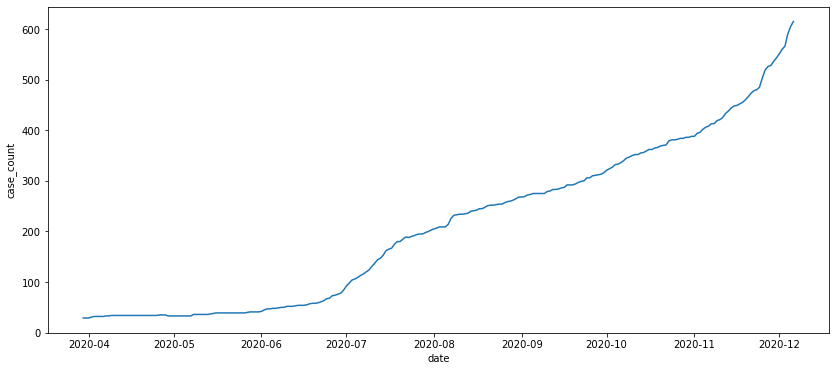

In [214]:
plt.figure(figsize=(14, 6))
g = sns.lineplot(data = covid_df.loc[covid_df.ziptext=='92037', :], x = 'date', y = 'case_count')

The previous plot was for only one zipcode, but lets try plotting with many! As we see below, certain zip codes increased in number of cases.

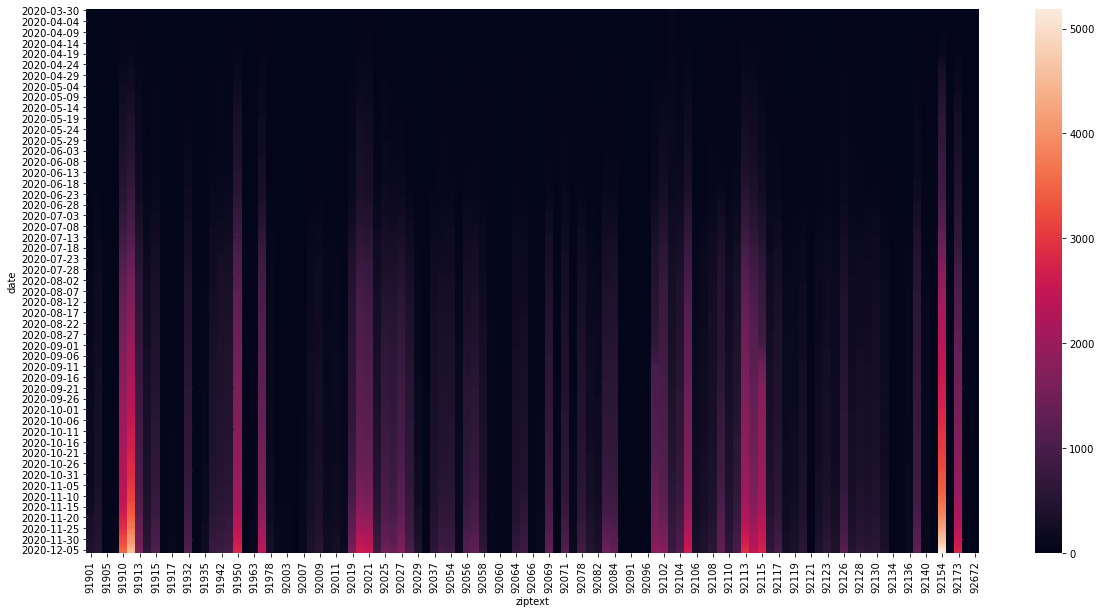

In [215]:
plt.figure(figsize=(20, 10))
g = sns.heatmap(covid_df_pivot)

Analyze incidents of asthma with case_count by zipcode. Clearly, the zipcodes where Asthma incidences were higher, show a higher case count.

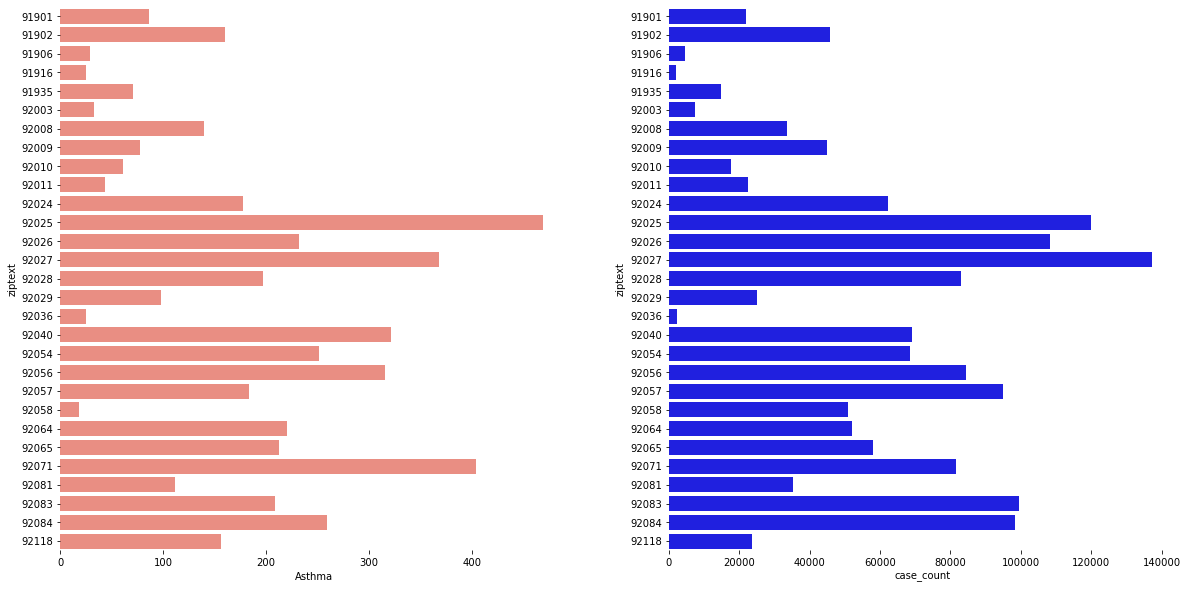

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
g1=sns.barplot(x='Asthma', y='ziptext', data=env_df, color = "salmon", orient = 'h', ax=ax1)
sns.despine(left=True, bottom=True)
g2=sns.barplot(x='case_count', y='ziptext', data=env_df, color = "blue", orient = 'h', ax=ax2)
sns.despine(left=True, bottom=True)

Analyze poverty with case_count by zipcode. Clearly, poverty is correlated with case count.

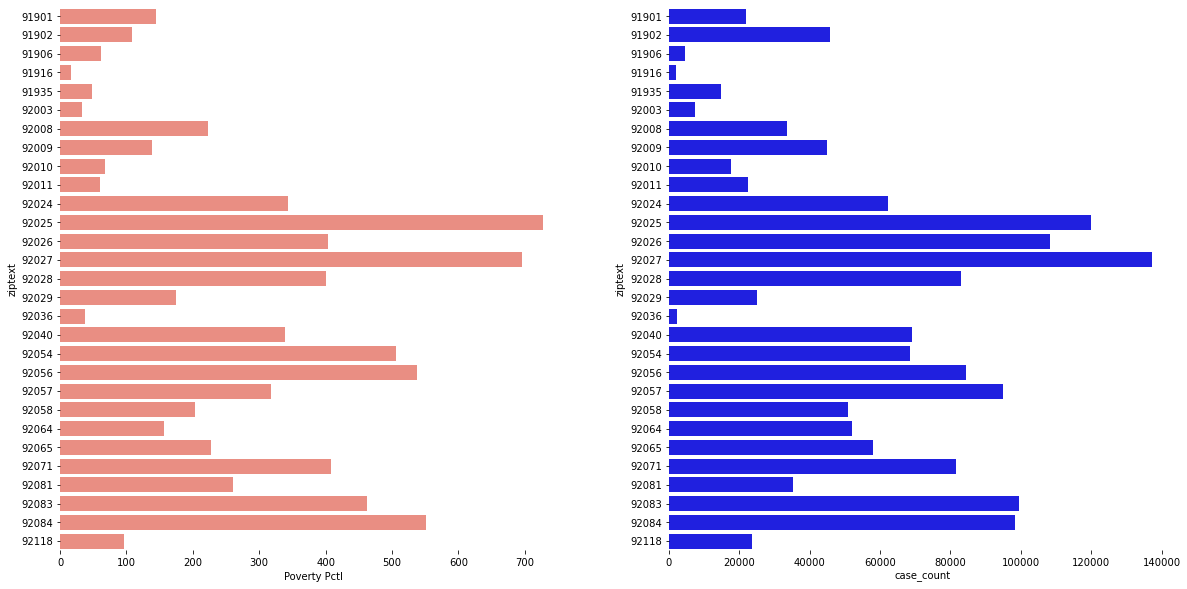

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
g1=sns.barplot(x='Poverty Pctl', y='ziptext', data=env_df, color = "salmon", orient = 'h', ax=ax1)
sns.despine(left=True, bottom=True)
g2=sns.barplot(x='case_count', y='ziptext', data=env_df, color = "blue", orient = 'h', ax=ax2)
sns.despine(left=True, bottom=True)

Analyze incidents of unemployment with case_count by zipcode. Clearly, the unemployment has a direct correlation with case count.

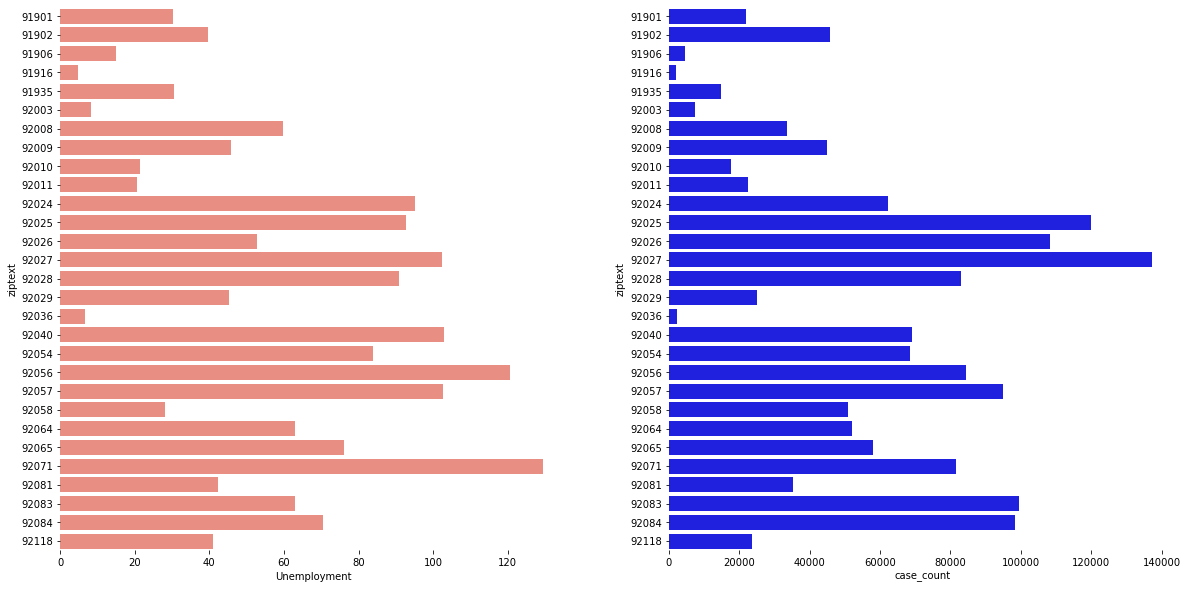

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
g1=sns.barplot(x='Unemployment', y='ziptext', data=env_df, color = "salmon", orient = 'h', ax=ax1)
sns.despine(left=True, bottom=True)
g2=sns.barplot(x='case_count', y='ziptext', data=env_df, color = "blue", orient = 'h', ax=ax2)
sns.despine(left=True, bottom=True)

The park revenues have shown a steady increase. In this case we had just taken revenue from concessions. 

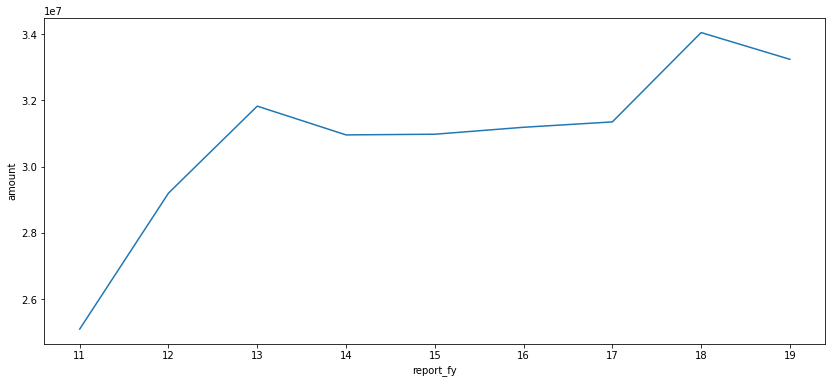

In [219]:
plt.figure(figsize=(14, 6))
g = sns.lineplot(data = op_df, x = 'report_fy', y = 'amount')

We used a linear regression model to predict future revenues. As we see, the revenue in 2025 is likely to be $38.6 million. 

In [239]:
regr = linear_model.LinearRegression()
X = op_df.report_fy.values.reshape(-1,1)
y = op_df.amount.values
regr.fit(X,y)
revenue = regr.predict(np.array([25]).reshape(-1,1))
revenue = int(revenue[0])
print('${:,}'.format(int(revenue)))

$38,609,212


## Ethics and Privacy

Since the data we use involves health conditions like Asthma and Covid, we need to be extremely careful that no personal or private information is exposed. All of the datasets that I had used were of public record and mostly from government sources. They did not have any personal or copyrighted information.

## Conclusion and Discussion

I restricted my analysis to San Diego, but this analysis can be broadened to any county as long as the data is available. 

It would have been nice to do a visualization with maps, which leaves room for improvement.

We found in this analysis that zipcodes with higher Covid cases also had higher Poverty, Unemployment, and Asthma rates. We performed a revenue prediction for the future using a linear regression model. In this case, we had only considered the revenue for park concessions. This can be expanded to include revenue from any other account heads. The idea behind this project was to equitably distribute the resources considering poverty, unemployment, and incidences of respiratory disorders.